# One-Shot Learning using Siamese Network in FastEstimator

This notebook demonstrates how to perform one-shot learning using Siamese Network in FastEstimator.

In one-shot learning we classify based on only a single example of each class. This ability of being able to learn from very little data could be useful in many machine learning problems.
The details of the method are present in [Siamese neural networks for one-shot image recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
We will use Omniglot dataset for training and evaluation. The Omniglot dataset consists of 50 different alphabets split into background(30 alphabets) and evaluation(20 alphabets) sets.Each alphabet has a number of characters and each character has 20 images each.

In [1]:
import os
import cv2
import time
from glob import glob

import numpy as np
import tensorflow as tf
import fastestimator as fe

import matplotlib
from matplotlib import pyplot as plt

## Step 1: Defining Input Pipeline

First, we will download the omnglot dataset which contains 1623 different handwritten characters from 50 different alphabets via our dataset API.
The images will be first downloaded from [here](https://github.com/brendenlake/omniglot/).
Then images for training and evaluation will be extracted and the path to them will be provided as train_path and eval_path

In [ ]:
from fastestimator.dataset.omniglot import load_data
train_path, eval_path = load_data()

Once the images are downloaded, we will use data generators which will read the data into memory and create batches for training and validation.
For training, batches of data are created with half of the batch consisting of image pair from the same character and other half consiting of image pair from different characters. The target label is 1 for image pair from the same character and 0 otherwise. The aim is to learn similarity between any given pair of images.

In [3]:
# Parameters
epochs = 50
batch_size = 128
steps_per_epoch = 500
validation_steps = 100

In [4]:
from fastestimator.dataset.omniglot import get_batch

data = {"train": lambda: get_batch(train_path, batch_size=batch_size), 
        "eval": lambda: get_batch(eval_path, batch_size=batch_size, is_train=False)}

We define a custom operator to augment portion of the input data as described in the [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). Given these operators we can now define `Pipeline` object.

In [5]:
from fastestimator.op import TensorOp
from fastestimator.op.tensorop import Minmax, Augmentation2D, Probability

pipeline = fe.Pipeline(
    data=data,
    batch_size=batch_size,
    ops=[
        Probability(
            tensor_op=Augmentation2D(inputs="x_a",
                                     outputs="x_a",
                                     mode="train",
                                     rotation_range=10.0,
                                     shear_range=-0.3 * 180 / np.pi,
                                     zoom_range=[0.8, 1.2],
                                     width_shift_range=0.05,
                                     height_shift_range=0.05),
            prob=0.89),
        Probability(
            tensor_op=Augmentation2D(inputs="x_b",
                                     outputs="x_b",
                                     mode="train",
                                     rotation_range=10.0,
                                     shear_range=-0.3 * 180 / np.pi,
                                     zoom_range=[0.8, 1.2],
                                     width_shift_range=0.05,
                                     height_shift_range=0.05),
            prob=0.89),
        Minmax(inputs="x_a", outputs="x_a"),
        Minmax(inputs="x_b", outputs="x_b")
    ])

We can visualize sample images from the ``pipeline`` using ``show_results`` method.
``show_results`` returns a list of batch data.

Image pair from same character


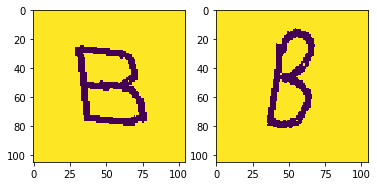

Image pair from different characters


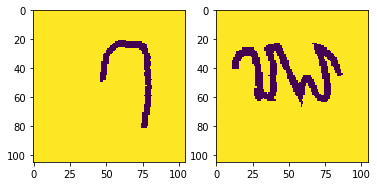

In [7]:
sample_batch = pipeline.show_results()
similar_img_a = sample_batch[0]["x_a"][0]
similar_img_b = sample_batch[0]["x_b"][0]

dissimilar_img_a = sample_batch[0]["x_a"][batch_size-1]
dissimilar_img_b = sample_batch[0]["x_b"][batch_size-1]

print('Image pair from same character')
plt.subplot(121)
plt.imshow(np.squeeze(similar_img_a))

plt.subplot(122)
plt.imshow(np.squeeze(similar_img_b))

plt.show()

print('Image pair from different characters')
plt.subplot(121)
plt.imshow(np.squeeze(dissimilar_img_a))

plt.subplot(122)
plt.imshow(np.squeeze(dissimilar_img_b))

plt.show()

## Step 2: Defining Model Architectures

Siamese network has two convolutional arms which accept distinct inputs. However, the weights on both these convolutional arms are shared. Each convolutional arm works as a feature extractor which produces a feature vector. L1 component-wise distance between these vectors is computed which is used to classify whether the image pair belongs to same or different classes. 

In [6]:
import tensorflow as tf
from tensorflow.python.keras import Model, layers, Sequential
from tensorflow.python.keras.initializers import RandomNormal
from tensorflow.python.keras.regularizers import l2
    

def siamese_network(input_shape=(105, 105, 1), classes=1):
    left_input = layers.Input(shape=input_shape)
    right_input = layers.Input(shape=input_shape)

    #Creating the convnet which shares weights between the left and right legs of Siamese network
    siamese_convnet = Sequential()

    siamese_convnet.add(
        layers.Conv2D(filters=64,
                      kernel_size=10,
                      strides=1,
                      input_shape=input_shape,
                      activation='relu',
                      kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                      kernel_regularizer=l2(1e-2),
                      bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    siamese_convnet.add(layers.MaxPooling2D(pool_size=(2, 2)))

    siamese_convnet.add(
        layers.Conv2D(filters=128,
                      kernel_size=7,
                      strides=1,
                      activation='relu',
                      kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                      kernel_regularizer=l2(1e-2),
                      bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    siamese_convnet.add(layers.MaxPooling2D(pool_size=(2, 2)))

    siamese_convnet.add(
        layers.Conv2D(filters=128,
                      kernel_size=4,
                      strides=1,
                      activation='relu',
                      kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                      kernel_regularizer=l2(1e-2),
                      bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    siamese_convnet.add(layers.MaxPooling2D(pool_size=(2, 2)))

    siamese_convnet.add(
        layers.Conv2D(filters=256,
                      kernel_size=4,
                      strides=1,
                      activation='relu',
                      kernel_initializer=RandomNormal(mean=0, stddev=0.01),
                      kernel_regularizer=l2(1e-2),
                      bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    siamese_convnet.add(layers.Flatten())

    siamese_convnet.add(
        layers.Dense(4096,
                     activation='sigmoid',
                     kernel_initializer=RandomNormal(mean=0, stddev=0.2),
                     kernel_regularizer=l2(1e-4),
                     bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))

    encoded_left_input = siamese_convnet(left_input)
    encoded_right_input = siamese_convnet(right_input)

    l1_encoded = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_left_input, encoded_right_input])

    output = layers.Dense(classes,
                          activation='sigmoid',
                          kernel_initializer=RandomNormal(mean=0, stddev=0.2),
                          bias_initializer=RandomNormal(mean=0.5, stddev=0.01))(l1_encoded)

    return Model(inputs=[left_input, right_input], outputs=output)

We now prepare the `model` and define a `Network` object.

In [7]:
from fastestimator.op.tensorop import ModelOp
from tensorflow.keras.optimizers import Adam
from fastestimator.op.tensorop import BinaryCrossentropy

model = fe.build(model_def=siamese_network, 
                 model_name="siamese_net", 
                 optimizer=Adam(learning_rate=1e-4), 
                 loss_name="loss")

network = fe.Network(ops=[
    ModelOp(inputs=["x_a", "x_b"], model=model, outputs="y_pred"),
    BinaryCrossentropy(inputs=("y", "y_pred"), outputs="loss")
])

In this example we will also use the following traces:
1. LRController with a constant decay schedule as described in the [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
2. ModelSaver for saving the model. For illustration purpose, we will save these models in temporary directory.
3. EarlyStopping for stopping training if the monitored metric doesn't improve within specified number of epochs.
4. Custom trace to calculate one shot classification accuracy as described in the [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
It's a 20-way within-alphabet classiﬁcation task in which an alphabet is ﬁrst chosen from among those reserved for the evaluation set. Then, nineteen other characters are taken uniformly at random from the alphabet. The first charcter's image is compared with another image of the same character and with images of the other nineteen characters. This is called a one-shot trial. The trial is considered a success if the network outputs highest similarity (probability) for the image pair belonging to same character. 

In [8]:
import tempfile
from fastestimator.trace import Trace, LRController, ModelSaver, EarlyStopping
from fastestimator.schedule import LRSchedule
from fastestimator.dataset.omniglot import one_shot_trial, load_eval_data


class LRDecaySchedule(LRSchedule):
    def __init__(self, decay_rate=0.99):
        super().__init__(schedule_mode="epoch")
        self.decay_rate = decay_rate

    def schedule_fn(self, current_step_or_epoch, lr):
        if current_step_or_epoch > 0:
            lr = np.float32(lr * self.decay_rate)
        return lr


class OneShotAccuracy(Trace):
    def __init__(self, model, img_list, N=20, trials_per_alphabet=40, mode="eval", output_name="one_shot_accuracy"):

        super().__init__(outputs=output_name, mode=mode)
        self.model = model
        self.total = 0
        self.correct = 0
        self.output_name = output_name
        self.img_list = img_list
        self.N = N
        self.trials_per_alphabet = trials_per_alphabet

    def on_epoch_begin(self, state):
        self.total = 0
        self.correct = 0

    def on_epoch_end(self, state):
        for alphabet in range(len(self.img_list)):

            for _ in range(self.trials_per_alphabet):
                input_img = one_shot_trial(self.img_list[alphabet], self.N)
                prediction_score = self.model(input_img).numpy()

                if np.argmax(prediction_score) == 0 and prediction_score.std() > 0.01:
                    self.correct += 1

                self.total += 1

        state[self.output_name] = self.correct / self.total

# Learning Rate Schedule
lr_scheduler = LRDecaySchedule(decay_rate=0.99)

# Loading images for validation one-shot accuracy
val_img_list = load_eval_data(path=eval_path, is_test=False)

# Model directory
model_dir=tempfile.mkdtemp()
os.makedirs(model_dir, exist_ok=True)
        
traces = [
    LRController(model_name="siamese_net", lr_schedule=lr_scheduler),
    OneShotAccuracy(model=model, img_list=val_img_list, output_name='one_shot_accuracy'),
    ModelSaver(model_name="siamese_net", save_dir=model_dir, save_best='one_shot_accuracy', save_best_mode='max'),
    EarlyStopping(monitor="one_shot_accuracy", patience=20, compare='max', mode="eval")
]

Finally, we are ready to define `Estimator` object and then call `fit` method to start the training.
Just for the sake of demo purpose, we would only run 50 epochs.

In [ ]:
estimator = fe.Estimator(network=network, 
                         pipeline=pipeline, 
                         epochs=epochs, 
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps,
                         traces=traces)
estimator.fit()

Below, we are infering results on the test dataset. Here, we choose a language and generate 5-way one shot trial for demo purposes.

In [11]:
from tensorflow.keras.models import load_model
saved_model = load_model(os.path.join(model_dir, 'siamese_net_best_one_shot_accuracy.h5'), compile=False)

In [12]:
# Language selected from Test Dataset
language = 'Manipuri'

characters = os.listdir(os.path.join(eval_path, language))

char_img_list = []
for character in characters:
    img_paths = glob(os.path.join(eval_path, language, character, "*.png"))
    imgs = [np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), -1) for i in img_paths]
    char_img_list.append(imgs)

#Generating one-shot trial set for 5-way one shot trial
input_img = one_shot_trial(char_img_list, 5)
prediction_score = saved_model.predict(input_img)

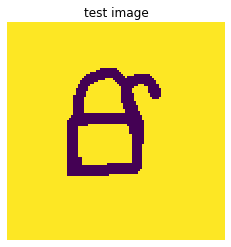

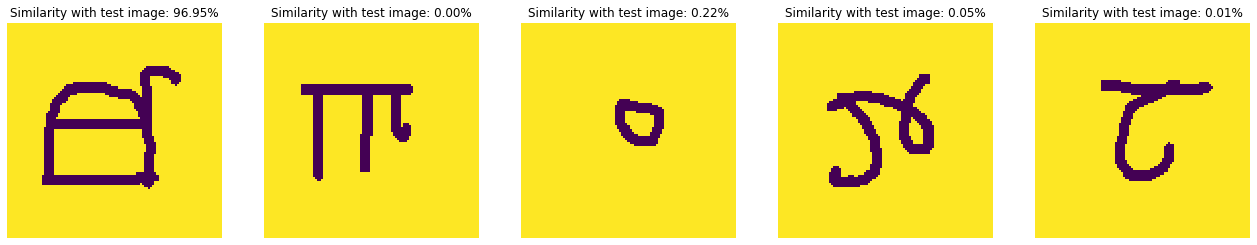

In [13]:
plt.figure(figsize=(4, 4))
plt.imshow(np.squeeze(input_img[0][0]));
plt.title('test image')
plt.axis('off');
plt.show()

plt.figure(figsize=(18, 18))
plt.subplot(151)
plt.imshow(np.squeeze(input_img[1][0]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[0][0]))
plt.axis('off');

plt.subplot(152)
plt.imshow(np.squeeze(input_img[1][1]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[1][0]))
plt.axis('off');

plt.subplot(153)
plt.imshow(np.squeeze(input_img[1][2]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[2][0]))
plt.axis('off');

plt.subplot(154)
plt.imshow(np.squeeze(input_img[1][3]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[3][0]))
plt.axis('off');

plt.subplot(155)
plt.imshow(np.squeeze(input_img[1][4]));
plt.title('Similarity with test image: {:0.2f}%'.format(100*prediction_score[4][0]))
plt.axis('off');

plt.tight_layout()

The test image is predicted to be belonging to the class with the maximum similarity. 